# Technisches Assessment | 05.07.2024 | Sebastian Archila

## Libraries

In [1]:
# Local imports
import re
import sqlite3

# Third-party imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Inhaltsverzeichnis

<p><a href="#1-extract">1. Extract</a></p>
<ul style="margin-left: 20px;">
    <a href="#11-data-check">1.1. Data Check</a>
</ul>

<p><a href="#2-transform">2. Transform</a></p>
<ul style="margin-left: 20px;">
    <p><a href="#21-general-analysis">2.1. General Analysis</a></p>
    <p><a href="#22-data-cleaning">2.2. Data Cleaning</a></p>
    <ul style="margin-left: 20px;">
        <li><a href="#zug-id">Zug id</a></li>
        <li><a href="#fahrtnummer">Fahrtnummer</a></li>
        <li><a href="#fahrzeugnummer">Fahrzeugnummer</a></li>
        <li><a href="#buchungskreis">Buchungskreis</a></li>
        <li><a href="#abfahrtsdatum">Abfahrtsdatum</a></li>
        <li><a href="#messung">Messung</a></li>
        <li><a href="#abfahrtszeit">Abfahrtszeit</a></li>
        <li><a href="#ankunftszeit">Ankunftszeit</a></li>
        <li><a href="#entfernung-km">Entfernung km</a></li>
        <li><a href="#passagieranzahl">Passagieranzahl</a></li>
        <li><a href="#abfahrtsbahnhof">Abfahrtsbahnhof</a></li>
        <li><a href="#ankunftsbahnhof">Ankunftsbahnhof</a></li>
        <li><a href="#final-transform-steps">Final Transform Steps</a></li>
    </ul>
    <p><a href="#23-reisezeit-in-minuten">2.3. Reisezeit in Minuten</a></p>
    <p><a href="#24-durchschnittliche-geschwindigkeit">2.4. Durchschnittliche Geschwindigkeit</a></p>
    <p><a href="#25-gesamtzahl-der-passagiere-pro-zug-pro-tag">2.5. Gesamtzahl der Passagiere pro Zug pro Tag</a></p>
</ul>

<p><a href="#3-load">3. Load</a></p>
<ul style="margin-left: 20px;">
    <p><a href="#31-load-data-to-sql-db">3.1. Load Data to SQL DB</a></p>
</ul>

<p><a href="#4-transform">4. Transform</a></p>
<ul style="margin-left: 20px;">
    <p><a href="#41-ausreißeranalyse">4.1. Ausreißeranalyse</a></p>
    <p><a href="#42-sql-abfragen">4.2. SQL Abfragen</a></p>
</ul>

<p><a href="#5-datenqualität">5. Datenqualität</a></p>
</ul>

## 1. Extract

### 1.1. Data check

In [2]:
# Load and create df
data_path = "data/zugfahrten.csv"
try:
    zugfahrten_df = pd.read_csv(data_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("File not found. Please provide a valid path.")
except Exception as e:
    print("An error occurred while loading the data:", e)

Data loaded successfully.


## 2. Transform

### 2.1. General analysis

In [3]:
# Explore data
print("Data shape:", zugfahrten_df.shape)
print("Column names:", zugfahrten_df.columns)

# Check the first few rows
zugfahrten_df.head()

Data shape: (26250, 12)
Column names: Index(['Fahrtnummer', 'Fahrzeugnummer', 'Buchungskreis', 'Abfahrtsdatum',
       'Messung', 'Zug id', 'Abfahrtszeit', 'Ankunftszeit', 'Entfernung km',
       'Passagieranzahl', 'Abfahrtsbahnhof', 'Ankunftsbahnhof'],
      dtype='object')


,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
0,3.094127e+09,1.0,1000,2020-12-29,2321.14,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
1,3.094127e+09,2.0,1000,2020-12-29,2361.35,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
2,3.094127e+09,3.0,1000,2020-12-29,3078.98,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
3,3.094127e+09,4.0,1000,2020-12-29,4063.26,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
4,3.094127e+09,5.0,1000,2020-12-29,624.47,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam


In [4]:
# Check the data types
zugfahrten_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26250 entries, 0 to 26249
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Fahrtnummer      26212 non-null  float64
 1   Fahrzeugnummer   26206 non-null  float64
 2   Buchungskreis    26209 non-null  object 
 3   Abfahrtsdatum    26216 non-null  object 
 4   Messung          26208 non-null  float64
 5   Zug id           26203 non-null  object 
 6   Abfahrtszeit     26198 non-null  object 
 7   Ankunftszeit     26218 non-null  object 
 8   Entfernung km    26201 non-null  object 
 9   Passagieranzahl  26212 non-null  object 
 10  Abfahrtsbahnhof  26215 non-null  object 
 11  Ankunftsbahnhof  26205 non-null  object 
dtypes: float64(3), object(9)
memory usage: 2.4+ MB


In [5]:
# Identify columns with null values
columns_with_null = zugfahrten_df.columns[zugfahrten_df.isna().any()]

# Print the columns with null values
print("Columns with null values:")
print(columns_with_null)
print("Number of missing values:\n", zugfahrten_df.isnull().sum())

Columns with null values:
Index(['Fahrtnummer', 'Fahrzeugnummer', 'Buchungskreis', 'Abfahrtsdatum',
       'Messung', 'Zug id', 'Abfahrtszeit', 'Ankunftszeit', 'Entfernung km',
       'Passagieranzahl', 'Abfahrtsbahnhof', 'Ankunftsbahnhof'],
      dtype='object')
Number of missing values:
 Fahrtnummer        38
Fahrzeugnummer     44
Buchungskreis      41
Abfahrtsdatum      34
Messung            42
Zug id             47
Abfahrtszeit       52
Ankunftszeit       32
Entfernung km      49
Passagieranzahl    38
Abfahrtsbahnhof    35
Ankunftsbahnhof    45
dtype: int64


### 2.2. Data Cleaning

#### Zug id

In [6]:
# List of unique values in Zug id
print("\nUnique values in Zug id:")
print(zugfahrten_df['Zug id'].unique())


Unique values in Zug id:
['3094127253' '8322069260' '9523145550' ... 'BJOUTUFYHN' 'JAUBUQTFAN'
 'OANNRSMDFS']


In [7]:
# Find rows where Zug id is missing
missing_zug_id_rows = zugfahrten_df[zugfahrten_df['Zug id'].isnull() | (zugfahrten_df['Zug id'] == '')]

# Display
print("Rows where Zug id is missing:")
display(missing_zug_id_rows.head())

Rows where Zug id is missing:


,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
1144,4.361218e+09,9.0,1004,2023-02-13,983.70,NaN,2024-06-08 13:34:40,2024-06-08 18:19:40,836,164,Jeremyberg,East Nancychester
2977,2.035955e+08,9.0,XXXX,2020-05-14,3582.34,NaN,2024-06-05 04:26:18,2024-06-05 07:08:18,688,230,South Jessicaville,New Gabriellaside
3461,2.914621e+09,1.0,1002,03/07/1998,2379.73,NaN,2024-05-27 07:04:47,2024-05-27 10:24:47,777,202,Lake Paulview,Joanchester
3556,6.373607e+09,5.0,XXXX,2021-12-11,3109.16,NaN,2024-06-08 08:07:57,2024-06-08 12:34:57,901,492,Thomaston,Martinezfurt
5039,7.338116e+09,9.0,1008,2023-05-02,1774.81,NaN,2024-06-22 23:01:58,2024-06-23 02:46:58,213,147,West Cathy,Whitestad


In [8]:
# Impute missing values in Zug id - loop 1
def impute_zug_id(df):
    for i in range(len(df)):
        if pd.isna(df.loc[i, 'Zug id']) or df.loc[i, 'Zug id'] == 'nan':
            # Check the Zug id value one row before
            if i >= 1 and pd.notna(df.loc[i-1, 'Zug id']) and df.loc[i-1, 'Zug id'] != 'nan':
                if (df.loc[i-1, 'Passagieranzahl'] == df.loc[i, 'Passagieranzahl'] and
                    df.loc[i-1, 'Abfahrtsbahnhof'] == df.loc[i, 'Abfahrtsbahnhof'] and
                    df.loc[i-1, 'Ankunftsbahnhof'] == df.loc[i, 'Ankunftsbahnhof']):
                    df.loc[i, 'Zug id'] = df.loc[i-1, 'Zug id']
            # If the row before is not valid, check the row after
            elif i < len(df) - 1 and pd.notna(df.loc[i+1, 'Zug id']) and df.loc[i+1, 'Zug id'] != 'nan':
                if (df.loc[i+1, 'Passagieranzahl'] == df.loc[i, 'Passagieranzahl'] and
                    df.loc[i+1, 'Abfahrtsbahnhof'] == df.loc[i, 'Abfahrtsbahnhof'] and
                    df.loc[i+1, 'Ankunftsbahnhof'] == df.loc[i, 'Ankunftsbahnhof']):
                    df.loc[i, 'Zug id'] = df.loc[i+1, 'Zug id']
    return df

zugfahrten_df = impute_zug_id(zugfahrten_df)

In [9]:
# Impute missing values in Zug id - loop 2
def impute_zug_id(df):
    for i in range(len(df)):
        if pd.isna(df.loc[i, 'Zug id']) or df.loc[i, 'Zug id'] == 'nan':
            # Check the Zug id value one row before
            if i >= 1 and pd.notna(df.loc[i-1, 'Zug id']):
                if (df.loc[i-1, 'Passagieranzahl'] == df.loc[i, 'Passagieranzahl'] and
                    df.loc[i-1, 'Abfahrtsbahnhof'] == df.loc[i, 'Abfahrtsbahnhof'] and
                    df.loc[i-1, 'Abfahrtszeit'] == df.loc[i, 'Abfahrtszeit'] and
                    df.loc[i-1, 'Ankunftsbahnhof'] == df.loc[i, 'Ankunftsbahnhof']):
                    df.loc[i, 'Zug id'] = df.loc[i-1, 'Zug id']
            # Check the Zug id value one row after if still missing
            if pd.isna(df.loc[i, 'Zug id']):
                if i < len(df) - 1 and pd.notna(df.loc[i+1, 'Zug id']):
                    if (df.loc[i+1, 'Passagieranzahl'] == df.loc[i, 'Passagieranzahl'] and
                        df.loc[i+1, 'Abfahrtsbahnhof'] == df.loc[i, 'Abfahrtsbahnhof'] and
                        df.loc[i+1, 'Abfahrtszeit'] == df.loc[i, 'Abfahrtszeit'] and
                        df.loc[i+1, 'Ankunftsbahnhof'] == df.loc[i, 'Ankunftsbahnhof']):
                        df.loc[i, 'Zug id'] = df.loc[i+1, 'Zug id']
    return df

zugfahrten_df = impute_zug_id(zugfahrten_df)

In [10]:
# Find rows where Zug id is missing
missing_zug_id_rows = zugfahrten_df[zugfahrten_df['Zug id'].isnull() | (zugfahrten_df['Zug id'] == '')]

# Display
print("Rows where Zug id is missing:")
display(missing_zug_id_rows)

Rows where Zug id is missing:


,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
25020,8.667541e+09,2.0,1007,24/12/2019,3014.11,NaN,2024-06-12 22:52:13,2024-06-13 02:25:13,882,268,West Jasonfort,Katherinetown
25884,7.699680e+09,5.0,1003,2023-03-25,3790.86,NaN,2024-05-28 07:15:17,2024-05-28 12:10:17,270,279,Duranfort,Hernandezshire
26229,8.480904e+09,11.0,1000,2021-02-24,4603.09,NaN,2024-05-29 11:11:48,2024-05-29 11:45:48,319,359,Amandaland,Lake Wendy


In [11]:
# Count the number of rows to be deleted
num_rows_deleted = missing_zug_id_rows.shape[0]

# Drop the rows with missing Zug id values
zugfahrten_df = zugfahrten_df.dropna(subset=['Zug id'])
zugfahrten_df = zugfahrten_df[zugfahrten_df['Zug id'] != '']

# Display the number of rows deleted
print(f"Number of rows deleted: {num_rows_deleted}")

Number of rows deleted: 3


<style>
    .conclusion-header {
        font-weight: bold;
        color: #BB0056;
        font-size: 1.5em;
        margin-bottom: 0.5em;
    }
    .conclusion-body {
        font-size: 1em;
        line-height: 1.5em;
        color: white;
    }
</style>

<div class="conclusion-header">Conclusion</div>
<div class="conclusion-body">
    Instead of deleting rows with missing values in <b>Zug id</b>, values were imputed. 
    Three rows still have missing values; however, those are repeated rows. 
    Therefore, just these three rows have been deleted.
</div>

In [12]:
# Define a regular expression pattern to match any string with a letter
pattern = re.compile(r'[a-zA-Z]')
rows_with_letters = zugfahrten_df[zugfahrten_df['Zug id'].apply(lambda x: bool(pattern.search(x)))]

# Display
print("Rows where Zug id contains letters:")
display(rows_with_letters)

Rows where Zug id contains letters:


,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
116,4.892646e+09,4.0,1003,2024-04-18,2088.06,UYJGLIEQFP,2024-06-11 00:06:46,2024-06-11 01:14:46,637,89,New Christopherview,North Crystalmouth
481,7.811937e+09,1.0,1005,2023-09-29,4985.06,GPMEHEITKD,2024-06-24 13:55:29,2024-06-24 15:24:29,880,342,Jamesstad,Meyerborough
482,7.811937e+09,2.0,1005,2023-09-29,761.21,TTMKEMIVRH,2024-06-24 13:55:29,2024-06-24 15:24:29,880,342,Jamesstad,Meyerborough
948,6.238971e+09,4.0,1000,2022-11-05,3617.33,OUCPNBQKFY,2024-05-31 22:57:29,2024-06-01 01:08:29,256,123,Lake Dan,Richardborough
961,7.808581e+09,12.0,XXXX,2020-01-10,3116.10,UKCLIBYGSZ,2024-06-21 04:35:34,2024-06-21 05:28:34,459,364,Jacquelineland,South Luis
...,...,...,...,...,...,...,...,...,...,...,...,...
24692,1.097616e+09,2.0,1005,2024-04-27,1390.32,VYKANFWFSJ,2024-06-24 22:19:04,2024-06-25 00:09:04,854,278,North Amandaland,Catherinetown
24777,6.176395e+09,2.0,1006,2020-04-14,2881.34,WBPGKZZDFC,2024-05-27 07:59:38,2024-05-27 09:59:38,150,354,Millerton,Port Nicholeside
25409,4.190075e+09,4.0,1007,2021-08-27,4076.53,BJOUTUFYHN,2024-06-11 13:55:33,2024-06-11 17:54:33,824,489,South Karabury,Michaelhaven
25586,2.497838e+09,4.0,1000,2021-11-16,506.18,JAUBUQTFAN,2024-05-27 18:23:51,2024-05-27 19:59:51,76,293,Brandonland,North Lisa


In [13]:
# Define a regular expression pattern to match any string with a letter
pattern = re.compile(r'[a-zA-Z]')
original_zugfahrten_df = zugfahrten_df.copy()

# Function to check and update 'Zug id'
def update_zug_id(index, direction):
    if 0 <= index + direction < len(zugfahrten_df):
        current_row = zugfahrten_df.iloc[index]
        adjacent_row = zugfahrten_df.iloc[index + direction]
        if (current_row['Buchungskreis'] == adjacent_row['Buchungskreis'] and
            current_row['Entfernung km'] == adjacent_row['Entfernung km'] and
            current_row['Abfahrtsbahnhof'] == adjacent_row['Abfahrtsbahnhof']):
            zugfahrten_df.at[index, 'Zug id'] = adjacent_row['Zug id']

# Function to perform a pass over the DataFrame
def perform_pass():
    for i, row in zugfahrten_df.iterrows():
        # Check if the current row's 'Zug id' contains letters
        if pattern.search(row['Zug id']):
            # Check and update from the previous row
            update_zug_id(i, -1)
            # Check and update from the next row
            update_zug_id(i, 1)

# First pass
perform_pass()

# Find rows where 'Zug id' was modified in the first pass
modified_rows_first_pass = zugfahrten_df[zugfahrten_df['Zug id'] != original_zugfahrten_df['Zug id']]

# Second pass to recheck and re-update 'Zug id' based on the modified DataFrame
perform_pass()

# Find rows where 'Zug id' was modified in the second pass
modified_rows_second_pass = zugfahrten_df[zugfahrten_df['Zug id'] != original_zugfahrten_df['Zug id']]

In [14]:
# Define a regular expression pattern to match any string with a letter
pattern = re.compile(r'[a-zA-Z]')

# Find rows where Zug id contains letters
rows_with_letters = zugfahrten_df[zugfahrten_df['Zug id'].apply(lambda x: bool(pattern.search(x)))]
zugfahrten_df = zugfahrten_df[~zugfahrten_df.index.isin(rows_with_letters.index)]

# Display these rows
print("Rows where Zug id contains letters:")
display(rows_with_letters)
print("-------------------")
print("New df:")
display(zugfahrten_df)

Rows where Zug id contains letters:


,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
25409,4.190075e+09,4.0,1007,2021-08-27,4076.53,BJOUTUFYHN,2024-06-11 13:55:33,2024-06-11 17:54:33,824,489,South Karabury,Michaelhaven
25586,2.497838e+09,4.0,1000,2021-11-16,506.18,JAUBUQTFAN,2024-05-27 18:23:51,2024-05-27 19:59:51,76,293,Brandonland,North Lisa
25815,3.808503e+09,7.0,1002,2023-07-28,4260.37,OANNRSMDFS,2024-05-29 02:35:26,2024-05-29 07:25:26,937,247,East Jason,Port Evanview


-------------------
New df:


,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
0,3.094127e+09,1.0,1000,2020-12-29,2321.14,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
1,3.094127e+09,2.0,1000,2020-12-29,2361.35,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
2,3.094127e+09,3.0,1000,2020-12-29,3078.98,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
3,3.094127e+09,4.0,1000,2020-12-29,4063.26,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
4,3.094127e+09,5.0,1000,2020-12-29,624.47,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
...,...,...,...,...,...,...,...,...,...,...,...,...
26245,1.551875e+09,15.0,1004,2024-04-30,3778.08,1551875283,2024-06-22 09:35:21,2024-06-22 10:46:21,560,398,Lake Adam,Johnsonbury
26246,2.685583e+09,5.0,1009,2021-08-20,4410.33,2685582618,2024-05-27 01:52:13,2024-05-27 06:15:13,640,478,North Cassandra,West Nicole
26247,7.811937e+09,2.0,1005,2023-09-29,761.21,7811937135,2024-06-24 13:55:29,2024-06-24 15:24:29,880,342,Jamesstad,Meyerborough
26248,4.366267e+09,15.0,1000,2020-01-28,3140.46,4366266646,2024-06-15 11:53:47,2024-06-15 13:39:47,576,149,South Michael,Hayesfort


<style>
    .conclusion-header {
        font-weight: bold;
        color: #BB0056;
        font-size: 1.5em;
        margin-bottom: 0.5em;
    }
    .conclusion-body {
        font-size: 1em;
        line-height: 1.5em;
        color: white;
    }
</style>

<div class="conclusion-header">Conclusion</div>
<div class="conclusion-body">
    Instead of deleting rows with alphabetic characters in the Zug id, the values were corrected. 
    However, three rows still contained alphabetic characters, since those enties are duplicates, they were deleted.
</div>

#### Fahrtnummer

In [15]:
# Drop the 'Fahrtnummer' column
zugfahrten_df = zugfahrten_df.drop(columns=['Fahrtnummer'])

# Display the DataFrame after deleting the column
print("DataFrame after deleting 'Fahrtnummer' column:")
display(zugfahrten_df.head())

DataFrame after deleting 'Fahrtnummer' column:


,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
0,1.0,1000,2020-12-29,2321.14,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
1,2.0,1000,2020-12-29,2361.35,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
2,3.0,1000,2020-12-29,3078.98,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
3,4.0,1000,2020-12-29,4063.26,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
4,5.0,1000,2020-12-29,624.47,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam


In [16]:
# Copy the 'Zug id' column and name it 'Fahrtnummer'
zugfahrten_df.insert(0, 'Fahrtnummer', zugfahrten_df['Zug id'])

# Display
print("DataFrame after copying 'Zug id' column to 'Fahrtnummer':")
display(zugfahrten_df.head())

DataFrame after copying 'Zug id' column to 'Fahrtnummer':


,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
0,3094127253,1.0,1000,2020-12-29,2321.14,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
1,3094127253,2.0,1000,2020-12-29,2361.35,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
2,3094127253,3.0,1000,2020-12-29,3078.98,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
3,3094127253,4.0,1000,2020-12-29,4063.26,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
4,3094127253,5.0,1000,2020-12-29,624.47,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam


<style>
    .conclusion-header {
        font-weight: bold;
        color: #BB0056;
        font-size: 1.5em;
        margin-bottom: 0.5em;
    }
    .conclusion-body {
        font-size: 1em;
        line-height: 1.5em;
        color: white;
    }
</style>

<div class="conclusion-header">Conclusion</div>
<div class="conclusion-body">
    This was done to maintain the correct format and to preserve the leading "0" in the IDs where required.
</div>

In [17]:
# Example for zero-indexed row
line_88 = zugfahrten_df.iloc[87]
print("Row at line 88:")
print(line_88)

Row at line 88:
Fahrtnummer                 0334669292
Fahrzeugnummer                    14.0
Buchungskreis                     1009
Abfahrtsdatum               2023-05-21
Messung                        4037.86
Zug id                      0334669292
Abfahrtszeit       2024-06-22 08:50:13
Ankunftszeit       2024-06-22 12:19:13
Entfernung km                      459
Passagieranzahl                    442
Abfahrtsbahnhof       Port Roberthaven
Ankunftsbahnhof              New Paula
Name: 87, dtype: object


### Fahrzeugnummer

In [18]:
# Check for duplicate rows based on all columns
duplicate_rows = zugfahrten_df[zugfahrten_df.duplicated()]

# Display the duplicate rows
print("Duplicate rows based on all columns:")
display(duplicate_rows)

Duplicate rows based on all columns:


,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
25000,6703658983,10.0,XXXX,2024-06-10,2333.12,6703658983,2024-06-09 21:40:44,2024-06-10 01:08:44,192,350,New Alexachester,East Annette
25001,3855774328,12.0,1003,2023-12-08,2914.65,3855774328,2024-06-19 15:47:24,2024-06-19 19:09:24,83,244,East Susanbury,Meyerstad
25002,4966654600,9.0,1001,2024-03-02,884.01,4966654600,2024-06-21 03:51:52,2024-06-21 05:54:52,505,394,Port Brittneytown,Jenniferbury
25003,2924503871,5.0,1003,2020-06-11,3465.87,2924503871,2024-06-08 04:28:15,2024-06-08 09:00:15,219,310,Williamtown,Tanyafurt
25004,7146049531,3.0,XXXX,2022-10-22,4469.59,7146049531,2024-05-31 02:52:58,2024-05-31 04:47:58,812,203,New Jillhaven,Lake Thomasview
...,...,...,...,...,...,...,...,...,...,...,...,...
26245,1551875283,15.0,1004,2024-04-30,3778.08,1551875283,2024-06-22 09:35:21,2024-06-22 10:46:21,560,398,Lake Adam,Johnsonbury
26246,2685582618,5.0,1009,2021-08-20,4410.33,2685582618,2024-05-27 01:52:13,2024-05-27 06:15:13,640,478,North Cassandra,West Nicole
26247,7811937135,2.0,1005,2023-09-29,761.21,7811937135,2024-06-24 13:55:29,2024-06-24 15:24:29,880,342,Jamesstad,Meyerborough
26248,4366266646,15.0,1000,2020-01-28,3140.46,4366266646,2024-06-15 11:53:47,2024-06-15 13:39:47,576,149,South Michael,Hayesfort


In [19]:
# Drop the duplicate
zugfahrten_df = zugfahrten_df.drop_duplicates()

In [20]:
# Display the rows where 'Fahrzeugnummer' has no values
rows_with_missing_fahrzeugnummer = zugfahrten_df[zugfahrten_df['Fahrzeugnummer'].isnull()]

# Display
display(rows_with_missing_fahrzeugnummer.head())    

,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
45,6944669989,NaN,1001,2020-09-18,3045.05,6944669989,2024-06-22 06:26:19,2024-06-22 10:22:19,493,95,North Stephaniemouth,East Eric
840,8237764087,NaN,1007,2022-10-02,1513.69,8237764087,2024-06-06 11:37:05,2024-06-06 15:13:05,918,105,North Alexandertown,Port Deanna
871,8695358391,NaN,1005,2023-02-03,2146.63,8695358391,2024-06-06 09:05:46,2024-06-06 11:27:46,690,350,West Alisonview,Port Anthony
2699,1262150578,NaN,1002,2024-01-05,1983.88,1262150578,2024-06-11 13:47:23,2024-06-11 17:31:23,498,428,Hortonport,South Victor
3016,1416452424,NaN,1004,2023-10-07,2577.26,1416452424,2024-06-04 00:11:12,2024-06-04 01:59:12,787,474,Michaelhaven,Port Nicholastown


In [21]:
# Ensure the Fahrzeugnummer column is treated as numeric values
zugfahrten_df['Fahrzeugnummer'] = pd.to_numeric(zugfahrten_df['Fahrzeugnummer'], errors='coerce')

# Fill missing values in 'Fahrzeugnummer'
for i in range(len(zugfahrten_df)):
    if pd.isna(zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Fahrzeugnummer')]):
        if i > 0 and zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Zug id')] == zugfahrten_df.iloc[i - 1, zugfahrten_df.columns.get_loc('Zug id')]:
            zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Fahrzeugnummer')] = zugfahrten_df.iloc[i - 1, zugfahrten_df.columns.get_loc('Fahrzeugnummer')] + 1
        elif i < len(zugfahrten_df) - 1 and zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Zug id')] == zugfahrten_df.iloc[i + 1, zugfahrten_df.columns.get_loc('Zug id')]:
            zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Fahrzeugnummer')] = zugfahrten_df.iloc[i + 1, zugfahrten_df.columns.get_loc('Fahrzeugnummer')] - 1

In [22]:
# Display the rows where 'Fahrzeugnummer' has no values
rows_with_missing_fahrzeugnummer = zugfahrten_df[zugfahrten_df['Fahrzeugnummer'].isnull()]

# Display
display(rows_with_missing_fahrzeugnummer)

,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
25225,4014906804,NaN,1004,2023-04-04,3280.63,4014906804,2024-06-21 18:46:57,2024-06-21 23:14:57,651,155,Lake Aaronberg,Santiagofurt
25306,8672585635,NaN,1008,2023-05-12,2735.81,8672585635,2024-06-02 08:24:52,2024-06-02 12:34:52,298,212,New Brett,Catherineberg
25541,1270865819,NaN,1008,2021-11-26,4424.59,1270865819,2024-06-06 03:23:19,2024-06-06 06:46:19,818,80,West Glennfort,Hoffmanfort
25833,4305878231,NaN,1000,2023-12-01,1252.93,4305878231,2024-06-03 10:17:40,2024-06-03 15:08:40,456,477,Taylorchester,Theodorechester
25973,8248983345,NaN,1000,2024-05-17,4225.10,8248983345,2024-06-25 16:30:52,2024-06-25 17:07:52,260,486,Bankstown,Hallport


### Buchungskreis 

In [23]:
# Display the rows where 'Buchungskreis' has no values
rows_with_missing_buchungskreis = zugfahrten_df[zugfahrten_df['Buchungskreis'].isnull()]

# Display
display(rows_with_missing_buchungskreis.head()) 

,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
59,2239050646,8.0,NaN,2022-02-10,1301.80,2239050646,2024-05-29 19:54:20,2024-05-29 21:33:20,538,473,Catherinechester,Collinschester
450,1065125257,10.0,NaN,2020-05-04,1979.80,1065125257,2024-06-25 13:35:13,2024-06-25 16:01:13,841,76,Morrismouth,Kathleenfurt
1031,4495325958,13.0,NaN,2021-06-01,4485.74,4495325958,2024-06-11 06:09:08,2024-06-11 10:45:08,215,483,Gayburgh,Elizabethview
1118,1474134785,1.0,NaN,2022-12-26,1180.10,1474134785,2024-06-02 17:31:56,2024-06-02 18:38:56,677,76,New Davidville,New Shannonborough
2608,0714499127,3.0,NaN,2021-09-01,990.05,0714499127,2024-06-07 18:07:33,2024-06-07 19:10:33,501,421,Mortonfort,Cantrellville


In [24]:
# Fill missing values in 'Buchungskreis'
for i in range(len(zugfahrten_df)):
    if pd.isna(zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Buchungskreis')]):
        if i > 0 and zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Zug id')] == zugfahrten_df.iloc[i - 1, zugfahrten_df.columns.get_loc('Zug id')]:
            zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Buchungskreis')] = zugfahrten_df.iloc[i - 1, zugfahrten_df.columns.get_loc('Buchungskreis')]
        elif i < len(zugfahrten_df) - 1 and zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Zug id')] == zugfahrten_df.iloc[i + 1, zugfahrten_df.columns.get_loc('Zug id')]:
            zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Buchungskreis')] = zugfahrten_df.iloc[i + 1, zugfahrten_df.columns.get_loc('Buchungskreis')]

In [25]:
# Display the rows where 'Buchungskreis' has no values
rows_with_missing_buchungskreis = zugfahrten_df[zugfahrten_df['Buchungskreis'].isnull()]

# Display
display(rows_with_missing_buchungskreis)

,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
25979,1535437009,3.0,NaN,2023-04-04,4554.83,1535437009,2024-06-22 09:11:08,2024-06-22 11:00:08,142,170,Luishaven,Alexanderside
26015,0656447169,1.0,NaN,2021-03-04,542.82,0656447169,2024-06-09 10:35:05,2024-06-09 13:38:05,304,394,West Amandachester,New Ann
26097,4653224538,5.0,NaN,2022-11-11,2017.93,4653224538,2024-05-30 01:56:14,2024-05-30 02:54:14,953,76,Joshuamouth,Osborneborough
26147,4694244410,11.0,NaN,2023-12-01,1381.83,4694244410,2024-06-15 12:21:57,2024-06-15 16:00:57,751,303,Timothytown,Jeffstad
26205,7942805615,3.0,NaN,2023-09-29,3635.70,7942805615,2024-06-01 05:55:41,2024-06-01 09:28:41,995,120,New Lindamouth,West Josephhaven


### Abfahrtsdatum

In [26]:
# Get unique values of 'Abfahrtsdatum'
unique_abfahrtsdatum = zugfahrten_df['Abfahrtsdatum'].unique()

# Display
print(unique_abfahrtsdatum)

['2020-12-29' '23/01/1999' '2021-03-14' ... '08/05/1970' '16/10/1988'
 '09/09/2011']


In [27]:
# Convert 'Abfahrtsdatum' to datetime
zugfahrten_df['Abfahrtsdatum'] = pd.to_datetime(zugfahrten_df['Abfahrtsdatum'], errors='coerce', dayfirst=True)

# Convert datetime to 'YYYY-MM-DD'
zugfahrten_df['Abfahrtsdatum'] = zugfahrten_df['Abfahrtsdatum'].dt.strftime('%Y-%m-%d')

# Display
display(zugfahrten_df.head())

C:\Users\SEA\AppData\Local\Temp\ipykernel_11840\3268051808.py:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  zugfahrten_df['Abfahrtsdatum'] = pd.to_datetime(zugfahrten_df['Abfahrtsdatum'], errors='coerce', dayfirst=True)


,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
0,3094127253,1.0,1000,2020-12-29,2321.14,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
1,3094127253,2.0,1000,2020-12-29,2361.35,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
2,3094127253,3.0,1000,2020-12-29,3078.98,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
3,3094127253,4.0,1000,2020-12-29,4063.26,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
4,3094127253,5.0,1000,2020-12-29,624.47,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam


In [28]:
# # Identify columns with null values
# columns_with_null = zugfahrten_df.columns[zugfahrten_df.isna().any()]

# # Print the columns with null values
# print("Columns with null values:")
# print(columns_with_null)
# print("Number of missing values:\n", zugfahrten_df.isnull().sum())

In [29]:
# # Display the rows where 'Abfahrtsdatum' has no values
# rows_with_missing_abfahrtsdatum = zugfahrten_df[zugfahrten_df['Abfahrtsdatum'].isnull()]

# # Display
# display(rows_with_missing_abfahrtsdatum)

In [30]:
# Fill missing values in 'Abfahrtsdatum'
for i in range(len(zugfahrten_df)):
    if pd.isna(zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Abfahrtsdatum')]):
        same_zug_id_rows = zugfahrten_df[zugfahrten_df['Zug id'] == zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Zug id')]]
        known_dates = same_zug_id_rows['Abfahrtsdatum'].dropna().unique()
        if known_dates.size > 0:
            zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Abfahrtsdatum')] = known_dates[0]

In [31]:
# Ensure the format is 'YYYY-MM-DD'
zugfahrten_df['Abfahrtsdatum'] = pd.to_datetime(zugfahrten_df['Abfahrtsdatum'], format='%Y-%m-%d', errors='coerce')

# Display the DataFrame to verify the changes
display(zugfahrten_df.head())

,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
0,3094127253,1.0,1000,2020-12-29,2321.14,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
1,3094127253,2.0,1000,2020-12-29,2361.35,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
2,3094127253,3.0,1000,2020-12-29,3078.98,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
3,3094127253,4.0,1000,2020-12-29,4063.26,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
4,3094127253,5.0,1000,2020-12-29,624.47,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam


In [32]:
# Check min and max values
min_abfahrtsdatum = zugfahrten_df['Abfahrtsdatum'].min()
max_abfahrtsdatum = zugfahrten_df['Abfahrtsdatum'].max()

# Print the results
print("Minimum Abfahrtsdatum:", min_abfahrtsdatum)
print("Maximum Abfahrtsdatum:", max_abfahrtsdatum)

Minimum Abfahrtsdatum: 2020-01-01 00:00:00
Maximum Abfahrtsdatum: 2024-06-24 00:00:00


### Messung

In [33]:
# Display the rows where 'Messung' has no values
rows_with_missing_messung = zugfahrten_df[zugfahrten_df['Messung'].isnull()]

# Display
display(rows_with_missing_messung.head())

,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
96,0939272042,1.0,1000,2020-06-15,NaN,0939272042,2024-06-20 11:10:28,2024-06-20 15:14:28,942,51,New Stevenstad,Smithshire
727,9417400399,13.0,1008,2020-02-12,NaN,9417400399,2024-06-15 08:14:42,2024-06-15 08:58:42,829,111,Port Jaredberg,Port Lauren
929,2150031639,3.0,1007,2020-12-03,NaN,2150031639,2024-06-09 05:11:25,2024-06-09 09:20:25,115,290,Connertown,South Danielland
3619,4116681925,2.0,1001,2021-04-28,NaN,4116681925,2024-06-07 22:02:24,2024-06-08 01:37:24,183,71,Williamsmouth,New Nicholasshire
4142,8577318898,15.0,1004,2022-11-27,NaN,8577318898,2024-06-14 17:46:24,performance,414,150,Allenland,East Angelbury


<style>
    .conclusion-header {
        font-weight: bold;
        color: #BB0056;
        font-size: 1.5em;
        margin-bottom: 0.5em;
    }
    .conclusion-body {
        font-size: 1em;
        line-height: 1.5em;
        color: white;
    }
</style>

<div class="conclusion-header">Conclusion</div>
<div class="conclusion-body">
    Since I was unsure about the definition of 'Messung', rows with missing values were dropped.
</div>

In [34]:
# Drop rows where 'Messung' is missing
zugfahrten_df = zugfahrten_df.dropna(subset=['Messung'])

In [35]:
# Check if negative values are present in 'Messung'
negative_messung_rows = zugfahrten_df[zugfahrten_df['Messung'] < 0]

# Display
display(negative_messung_rows)

,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
345,7805182368,18.0,1003,2022-10-20,-4366.95,7805182368,2024-06-17 19:51:58,2024-06-17 20:23:58,254,397,Geraldton,New Samuelbury
434,7545549641,2.0,1004,2020-10-30,-1301.68,7545549641,2024-06-09 06:52:41,2024-06-09 07:29:41,319,88,Lake Loritown,Summersport
538,0968001324,5.0,1001,2024-02-02,-2428.31,0968001324,2024-06-15 17:59:57,2024-06-15 19:25:57,933,311,North Francis,West Allisonburgh
589,3553892234,14.0,1007,2022-10-23,-1756.43,3553892234,2024-06-01 16:45:05,2024-06-01 17:16:05,914,221,Lake Timothystad,South Tylerborough
1264,4891449806,15.0,XXXX,2021-07-02,-1698.78,4891449806,2024-06-17 04:53:37,2024-06-17 07:21:37,600,475,North Danielle,North Sarah
...,...,...,...,...,...,...,...,...,...,...,...,...
25587,8932915102,17.0,1008,2023-03-29,-4725.68,8932915102,2024-06-02 07:42:37,2024-06-02 10:38:37,613,244,Lake Scottmouth,Warrenborough
25652,5741870212,6.0,1003,2020-07-28,-1155.67,5741870212,2024-06-02 13:28:00,2024-06-02 16:44:00,339,168,North Richard,Chasebury
25950,0291777048,13.0,1008,2023-08-23,-4451.26,0291777048,2024-05-27 15:42:01,2024-05-27 17:48:01,798,140,Lake David,Danielville
26101,8674828977,2.0,1001,2022-06-26,-781.35,8674828977,2024-06-08 17:10:28,2024-06-08 21:06:28,765,398,Calderonburgh,East Brian


In [36]:
# Reset the index to ensure default integer indexing
zugfahrten_df.reset_index(drop=True, inplace=True)

# Correct negative values in 'Messung' based on 'Zug id'
for i in range(len(zugfahrten_df)):
    if zugfahrten_df.loc[i, 'Messung'] < 0:
        # Check the row before
        if i > 0 and zugfahrten_df.loc[i, 'Zug id'] == zugfahrten_df.loc[i - 1, 'Zug id']:
            zugfahrten_df.loc[i, 'Messung'] = abs(zugfahrten_df.loc[i, 'Messung'])
        # Check the row after
        elif i < len(zugfahrten_df) - 1 and zugfahrten_df.loc[i, 'Zug id'] == zugfahrten_df.loc[i + 1, 'Zug id']:
            zugfahrten_df.loc[i, 'Messung'] = abs(zugfahrten_df.loc[i, 'Messung'])

# Delete rows where 'Messung' has a negative value
zugfahrten_df = zugfahrten_df[zugfahrten_df['Messung'] >= 0]

In [37]:
# Ensure there are no negative values in 'Messung'
negative_messung_rows = zugfahrten_df[zugfahrten_df['Messung'] < 0]

# Display
display(negative_messung_rows)

,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof


<style>
    .conclusion-header {
        font-weight: bold;
        color: #BB0056;
        font-size: 1.5em;
        margin-bottom: 0.5em;
    }
    .conclusion-body {
        font-size: 1em;
        line-height: 1.5em;
        color: white;
    }
</style>

<div class="conclusion-header">Conclusion</div>
<div class="conclusion-body">
    For the same reason that I was unsure of the definition of 'Messung', negative numbers were converted to positive only if they were surrounded by the same 'Zug id'. The remaining negative values (approximately 5) were deleted.
</div>

### Abfahrtszeit       

In [38]:
# Get unique values of 'Abfahrtszeit'
unique_abfahrtszeit = zugfahrten_df['Abfahrtszeit'].unique()

# Display
print(unique_abfahrtszeit)

['2024-06-11 23:31:02' '2024-06-13 07:45:16' '2024-06-08 10:40:11' ...
 'security' 'relationship' 'somebody']


In [39]:
# Convert 'Abfahrtszeit' to datetime, coercing errors
zugfahrten_df['Abfahrtszeit'] = pd.to_datetime(zugfahrten_df['Abfahrtszeit'], errors='coerce')

# Display
display(zugfahrten_df.head())

,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
0,3094127253,1.0,1000,2020-12-29,2321.14,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
1,3094127253,2.0,1000,2020-12-29,2361.35,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
2,3094127253,3.0,1000,2020-12-29,3078.98,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
3,3094127253,4.0,1000,2020-12-29,4063.26,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam
4,3094127253,5.0,1000,2020-12-29,624.47,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688,470,Millerside,Lake Adam


In [40]:
# # Identify columns with null values
# columns_with_null = zugfahrten_df.columns[zugfahrten_df.isna().any()]

# # Print the columns with null values
# print("Columns with null values:")
# print(columns_with_null)
# print("Number of missing values:\n", zugfahrten_df.isnull().sum())

In [41]:
# Fill missing values in 'Abfahrtszeit'
for i in range(len(zugfahrten_df)):
    if pd.isna(zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Abfahrtszeit')]):
        same_zug_id_rows = zugfahrten_df[zugfahrten_df['Zug id'] == zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Zug id')]]
        known_dates = same_zug_id_rows['Abfahrtszeit'].dropna().unique()
        if known_dates.size > 0:
            zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Abfahrtszeit')] = known_dates[0]

In [42]:
# Check min and max values
min_abfahrtszeit = zugfahrten_df['Abfahrtszeit'].min()
max_abfahrtszeit = zugfahrten_df['Abfahrtszeit'].max()

# Print the results
print("Minimum Abfahrtszeit:", min_abfahrtszeit)
print("Maximum Abfahrtszeit:", max_abfahrtszeit)

Minimum Abfahrtszeit: 2024-05-26 23:28:38
Maximum Abfahrtszeit: 2024-06-25 23:18:44


### Ankunftszeit     

In [43]:
# Get unique values of 'Ankunftszeit'
unique_ankunftszeit = zugfahrten_df['Ankunftszeit'].unique()

# Display
print(unique_ankunftszeit)

['2024-06-12 02:02:02' '2024-06-13 09:38:16' '2024-06-08 14:24:11' ...
 'fire' 'build' 'interesting']


In [44]:
# Convert 'Ankunftszeit' to datetime, coercing errors
zugfahrten_df['Ankunftszeit'] = pd.to_datetime(zugfahrten_df['Ankunftszeit'], errors='coerce')

# Format 'Ankunftszeit' to 'YYYY-MM-DD HH:MM:SS'
zugfahrten_df['Ankunftszeit'] = zugfahrten_df['Ankunftszeit'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [45]:
# Fill missing values in 'Ankunftszeit'
for i in range(len(zugfahrten_df)):
    if pd.isna(zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Ankunftszeit')]):
        same_zug_id_rows = zugfahrten_df[zugfahrten_df['Zug id'] == zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Zug id')]]
        known_dates = same_zug_id_rows['Ankunftszeit'].dropna().unique()
        if known_dates.size > 0:
            zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Ankunftszeit')] = known_dates[0]

In [46]:
# Check min and max values
min_ankunftszeit = zugfahrten_df['Ankunftszeit'].min()
max_ankunftszeit = zugfahrten_df['Ankunftszeit'].max()

# Print the results
print("Minimum Ankunftszeit:", min_ankunftszeit)
print("Maximum Ankunftszeit:", max_ankunftszeit)

Minimum Ankunftszeit: 2024-05-27 01:19:57
Maximum Ankunftszeit: 2024-07-05 01:37:12


In [47]:
# Filter rows where 'Abfahrtszeit' is not earlier than 'Ankunftszeit'
false_rows = zugfahrten_df[zugfahrten_df['Abfahrtszeit'] >= zugfahrten_df['Ankunftszeit']]

# Display the rows where 'Abfahrtszeit' is not earlier than 'Ankunftszeit'
print(false_rows)

Empty DataFrame
Columns: [Fahrtnummer, Fahrzeugnummer, Buchungskreis, Abfahrtsdatum, Messung, Zug id, Abfahrtszeit, Ankunftszeit, Entfernung km, Passagieranzahl, Abfahrtsbahnhof, Ankunftsbahnhof]
Index: []


### Entfernung km

In [48]:
# Get unique values of 'Entfernung km'
unique_entfernung = zugfahrten_df['Entfernung km'].unique()

# Display
print(unique_entfernung)

['688' '531' '624' '493' '538' '464' '578' '459' '495' '942' '637' '662'
 '132' '906' '755' nan '918' '958' '800' '354' '582' '481' '545' '254'
 '92' '398' '440' '744' '100' '853' '677' '319' '841' '287' '980' '919'
 '880' '608' '740' '144' '231' '235' '933' '691' '650' '211' '439' '914'
 '67' '861' '426' '473' '62' 'smile' '928' '569' '962' '185' '829' '748'
 '912' '299' '683' '660' '97' '947' '438' '944' '322' '364' '690' '782'
 '524' '230' '115' '117' '142' '256' '629' '542' '659' '586' '215' '345'
 '469' '384' '145' '571' '836' '270' '366' '898' '284' '435' '726' '816'
 '521' '68' '600' '840' '642' '534' '576' '612' '785' '911' '625' '597'
 '489' '870' '447' '990' '251' '157' '653' '401' 'show' '71' '51' '172'
 '240' '110' '336' '893' '930' '207' '421' '80' '956' '544' '805' '378'
 '982' '360' '596' '467' '985' '878' '88' '134' '988' '292' '719' '347'
 '487' '983' '160' '831' '894' '736' '808' '814' '602' '410' '689' '617'
 '810' '648' '131' '408' 'begin' '355' '762' '888' '484' '3

In [49]:
# Replace non-numeric values with NaN
zugfahrten_df['Entfernung km'] = pd.to_numeric(zugfahrten_df['Entfernung km'], errors='coerce')

# Display
display(zugfahrten_df)

,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
0,3094127253,1.0,1000,2020-12-29,2321.14,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688.0,470,Millerside,Lake Adam
1,3094127253,2.0,1000,2020-12-29,2361.35,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688.0,470,Millerside,Lake Adam
2,3094127253,3.0,1000,2020-12-29,3078.98,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688.0,470,Millerside,Lake Adam
3,3094127253,4.0,1000,2020-12-29,4063.26,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688.0,470,Millerside,Lake Adam
4,3094127253,5.0,1000,2020-12-29,624.47,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688.0,470,Millerside,Lake Adam
...,...,...,...,...,...,...,...,...,...,...,...,...
25101,0799554257,11.0,1008,2023-05-19,4205.58,0799554257,2024-06-15 22:31:26,2024-06-16 02:37:26,875.0,227,Tiffanymouth,Port Aliciaport
25102,4191950654,9.0,1000,2023-06-17,3872.10,4191950654,2024-06-13 13:15:21,2024-06-13 17:40:21,129.0,266,NaN,Mataton
25103,0117443352,3.0,1004,2023-08-01,4294.16,0117443352,2024-06-08 15:11:53,2024-06-08 18:39:53,627.0,414,South Jordanstad,Port Karen
25104,7772769811,1.0,1002,2022-10-22,3249.77,7772769811,2024-06-19 01:18:57,2024-06-19 06:10:57,484.0,304,Smithmouth,North Sarah


In [50]:
# Display the rows where 'Entfernung km' has no values
rows_with_entfernung = zugfahrten_df[zugfahrten_df['Entfernung km'].isnull()]

# Display
display(rows_with_entfernung)

,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
179,0739456991,4.0,1002,2023-09-23,1833.13,0739456991,2024-06-08 13:20:24,2024-06-08 17:45:24,NaN,183,East Walterbury,North Craigbury
655,7868722371,4.0,1004,2020-08-24,4491.53,7868722371,2024-06-02 14:38:00,2024-06-02 15:58:00,NaN,50,Thomasshire,Stanleyburgh
1454,7512879927,8.0,1007,2022-06-15,4500.71,7512879927,2024-05-27 05:40:33,2024-05-27 09:33:33,NaN,292,Isaacland,South Robertmouth
2040,0805179586,5.0,1009,2022-07-10,1157.11,0805179586,2024-06-02 08:16:17,2024-06-02 10:40:17,NaN,143,Carlsonchester,Williamsview
2062,9396096446,9.0,1005,2022-08-28,2373.35,9396096446,2024-06-06 10:16:23,2024-06-06 14:43:23,NaN,55,North Thomasberg,North Victoriaberg
...,...,...,...,...,...,...,...,...,...,...,...,...
25002,1388934800,12.0,1003,2024-04-06,2929.03,1388934800,2024-06-13 17:32:02,2024-06-13 18:51:02,NaN,441,Brittanytown,Wrightchester
25010,3896788145,5.0,1007,2023-05-15,913.05,3896788145,2024-06-10 11:27:06,2024-06-10 12:50:06,NaN,91,West Savannahport,Mooretown
25018,1519602640,7.0,1007,2020-01-05,3057.13,1519602640,2024-05-27 05:33:56,2024-05-27 06:26:56,NaN,356,North Theresa,Port Davidside
25028,3949411792,3.0,1005,2024-03-04,1094.30,3949411792,2024-06-14 06:56:31,2024-06-14 11:23:31,NaN,443,South Kyle,Stephenville


In [51]:
# Fill missing values in 'Entfernung km'
for i in range(len(zugfahrten_df)):
    if pd.isna(zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Entfernung km')]):
        if i > 0 and zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Zug id')] == zugfahrten_df.iloc[i - 1, zugfahrten_df.columns.get_loc('Zug id')]:
            zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Entfernung km')] = zugfahrten_df.iloc[i - 1, zugfahrten_df.columns.get_loc('Entfernung km')]
        elif i < len(zugfahrten_df) - 1 and zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Zug id')] == zugfahrten_df.iloc[i + 1, zugfahrten_df.columns.get_loc('Zug id')]:
            zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Entfernung km')] = zugfahrten_df.iloc[i + 1, zugfahrten_df.columns.get_loc('Entfernung km')]

In [52]:
# Display the rows where ''Entfernung km' has no values
rows_with_entfernung = zugfahrten_df[zugfahrten_df['Entfernung km'].isnull()]

# Display
print("Rows where 'Entfernung km' has no values before conversion:")
display(rows_with_entfernung)

Rows where 'Entfernung km' has no values before conversion:


,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
24965,1929538854,13.0,1007,2022-07-29,4566.76,1929538854,2024-06-09 20:49:51,2024-06-09 23:39:51,NaN,250,Cochranside,South Rachel
24974,9935879448,15.0,1000,2020-06-27,4611.10,9935879448,2024-05-27 22:59:07,2024-05-28 00:55:07,NaN,124,South Conniestad,Port Arthurview
25002,1388934800,12.0,1003,2024-04-06,2929.03,1388934800,2024-06-13 17:32:02,2024-06-13 18:51:02,NaN,441,Brittanytown,Wrightchester
25010,3896788145,5.0,1007,2023-05-15,913.05,3896788145,2024-06-10 11:27:06,2024-06-10 12:50:06,NaN,91,West Savannahport,Mooretown
25018,1519602640,7.0,1007,2020-01-05,3057.13,1519602640,2024-05-27 05:33:56,2024-05-27 06:26:56,NaN,356,North Theresa,Port Davidside
25028,3949411792,3.0,1005,2024-03-04,1094.30,3949411792,2024-06-14 06:56:31,2024-06-14 11:23:31,NaN,443,South Kyle,Stephenville
25105,7705851007,3.0,1009,2020-05-20,969.09,7705851007,2024-06-20 05:17:37,2024-06-20 10:01:37,NaN,358,South Craighaven,Cummingsfort


<style>
    .conclusion-header {
        font-weight: bold;
        color: #BB0056;
        font-size: 1.5em;
        margin-bottom: 0.5em;
    }
    .conclusion-body {
        font-size: 1em;
        line-height: 1.5em;
        color: white;
    }
</style>

<div class="conclusion-header">Conclusion</div>
<div class="conclusion-body">
    The remaining rows are likely duplicates, which will be deleted later.
</div>

In [53]:
# Check min and max values
min_entfernung = zugfahrten_df['Entfernung km'].min()
max_entfernung = zugfahrten_df['Entfernung km'].max()

# Print the results
print("Minimum Entfernung km:", min_entfernung)
print("Maximum Entfernung km:", max_entfernung)

Minimum Entfernung km: 50.0
Maximum Entfernung km: 1000.0


### Passagieranzahl    

In [54]:
# Display the rows where 'Passagieranzahl' has no values
rows_with_missing_passagieranzahl = zugfahrten_df[zugfahrten_df['Passagieranzahl'].isnull()]

# Display
display(rows_with_missing_passagieranzahl.head())

,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
2388,9777939530,15.0,1008,2020-06-19,4000.63,9777939530,2024-06-08 21:27:13,2024-06-08 23:35:13,108.0,NaN,East Kylehaven,North Christinashire
3101,5249158181,4.0,1005,2020-03-07,4209.47,5249158181,2024-06-19 23:45:53,2024-06-20 02:06:53,413.0,NaN,West Laurafurt,Scottside
3152,1696083073,12.0,1006,2022-11-01,3696.59,1696083073,2024-06-13 21:53:04,2024-06-14 02:27:04,248.0,NaN,North Jennifer,Cindychester
4271,3041826626,19.0,1002,2023-09-22,4191.76,3041826626,2024-06-18 15:55:32,2024-06-18 19:24:32,100.0,NaN,South Pedro,Ericaland
4781,0873473026,5.0,1006,2023-10-25,3535.76,0873473026,2024-06-23 22:33:20,2024-06-24 03:32:20,723.0,NaN,South Josephview,North Robertview


In [55]:
# Get unique values of 'Passagieranzahl'
unique_entfernung = zugfahrten_df['Passagieranzahl'].unique()

# Display
print(unique_entfernung)

['470' '190' '77' '95' '473' '324' '268' '442' '82' '51' '89' '173' '132'
 '368' '183' '247' '50' '441' '451' 'important' '102' '372' 'still' '318'
 'audience' '366' '70' '397' '316' '385' '347' '221' '180' '336' '88' '76'
 '370' '140' '479' '342' '439' '325' '293' '462' '418' '311' '433' '400'
 '493' '93' 'ball' '382' '161' '124' '236' '256' '234' '211' '165' '111'
 '289' '71' '437' 'collection' '412' '307' '169' '223' '83' '411' '105'
 '259' '350' '308' '118' '340' '290' '319' '123' '364' '128' '79' '100'
 '483' '302' '327' '227' '182' '164' '485' '146' '468' '297' '393' '196'
 '475' '337' '217' '496' '239' '436' 'policy' '74' '152' '374' '264' '125'
 '484' '425' '396' '230' 'last' '292' '481' '384' '453' '75' '97' '249'
 '141' '330' '309' '346' '287' '489' '224' '189' '250' '492' '378' '335'
 '275' 'instead' '300' '381' '263' 'edge' '109' '298' '345' '193' '131'
 '495' '139' '359' '315' '399' '225' '499' '261' '208' '170' '143' 'sport'
 '55' '98' '73' '304' '394' '69' '137' '267' '4

In [56]:
# Replace non-numeric values with NaN
zugfahrten_df['Passagieranzahl'] = pd.to_numeric(zugfahrten_df['Passagieranzahl'], errors='coerce')

In [57]:
# Get unique values of 'Passagieranzahl'
unique_entfernung = zugfahrten_df['Passagieranzahl'].unique()

# Display
print(unique_entfernung)

[470. 190.  77.  95. 473. 324. 268. 442.  82.  51.  89. 173. 132. 368.
 183. 247.  50. 441. 451.  nan 102. 372. 318. 366.  70. 397. 316. 385.
 347. 221. 180. 336.  88.  76. 370. 140. 479. 342. 439. 325. 293. 462.
 418. 311. 433. 400. 493.  93. 382. 161. 124. 236. 256. 234. 211. 165.
 111. 289.  71. 437. 412. 307. 169. 223.  83. 411. 105. 259. 350. 308.
 118. 340. 290. 319. 123. 364. 128.  79. 100. 483. 302. 327. 227. 182.
 164. 485. 146. 468. 297. 393. 196. 475. 337. 217. 496. 239. 436.  74.
 152. 374. 264. 125. 484. 425. 396. 230. 292. 481. 384. 453.  75.  97.
 249. 141. 330. 309. 346. 287. 489. 224. 189. 250. 492. 378. 335. 275.
 300. 381. 263. 109. 298. 345. 193. 131. 495. 139. 359. 315. 399. 225.
 499. 261. 208. 170. 143.  55.  98.  73. 304. 394.  69. 137. 267. 421.
 215. 422. 231. 314. 155. 465. 280. 373. 467. 380. 328. 466. 389. 255.
 241. 295. 159. 158. 358. 463.  63. 444. 284. 303. 133. 226. 160. 417.
 265. 428. 212. 138. 488. 424. 233. 410. 379. 478. 416. 426. 449. 480.
 266. 

In [58]:
# Fill missing values in 'Passagieranzahl'
for i in range(len(zugfahrten_df)):
    if pd.isna(zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Passagieranzahl')]):
        if i > 0 and zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Zug id')] == zugfahrten_df.iloc[i - 1, zugfahrten_df.columns.get_loc('Zug id')]:
            zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Passagieranzahl')] = zugfahrten_df.iloc[i - 1, zugfahrten_df.columns.get_loc('Passagieranzahl')]
        elif i < len(zugfahrten_df) - 1 and zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Zug id')] == zugfahrten_df.iloc[i + 1, zugfahrten_df.columns.get_loc('Zug id')]:
            zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Passagieranzahl')] = zugfahrten_df.iloc[i + 1, zugfahrten_df.columns.get_loc('Passagieranzahl')]

In [59]:
# Check min and max values
min_passagieranzahl = zugfahrten_df['Passagieranzahl'].min()
max_passagieranzahl = zugfahrten_df['Passagieranzahl'].max()

# Print the results
print("Minimum Passagieranzahl:", min_passagieranzahl)
print("Maximum Passagieranzahl:", max_passagieranzahl)

Minimum Passagieranzahl: 50.0
Maximum Passagieranzahl: 500.0


In [60]:
# Display the rows where 'Passagieranzahl' has no values
rows_with_missing_messung = zugfahrten_df[zugfahrten_df['Passagieranzahl'].isnull()]

# Display
display(rows_with_missing_messung)

,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
25001,7937698187,5.0,XXXX,2020-12-01,2135.35,7937698187,2024-06-08 13:11:43,2024-06-08 15:40:43,857.0,NaN,Christophermouth,Port Nataliebury
25042,0202022090,6.0,1005,2020-05-09,2529.34,0202022090,2024-06-13 13:42:41,2024-06-13 16:23:41,713.0,NaN,South Christinestad,West Amber
25051,5115563759,8.0,1000,2022-01-05,1011.87,5115563759,2024-06-16 12:57:02,2024-06-16 15:43:02,901.0,NaN,Diazbury,Boydburgh
25090,2245341804,14.0,1008,2023-04-07,936.38,2245341804,2024-06-05 01:43:48,2024-06-05 04:01:48,89.0,NaN,Robinport,West Aprilshire


<style>
    .conclusion-header {
        font-weight: bold;
        color: #BB0056;
        font-size: 1.5em;
        margin-bottom: 0.5em;
    }
    .conclusion-body {
        font-size: 1em;
        line-height: 1.5em;
        color: white;
    }
</style>

<div class="conclusion-header">Conclusion</div>
<div class="conclusion-body">
    The remaining rows are likely duplicates, which will be deleted later.
</div>

### Abfahrtsbahnhof    

In [61]:
# Display the rows where 'Abfahrtsbahnhof' has no values
rows_with_missing_abfahrtsbahnhof = zugfahrten_df[zugfahrten_df['Abfahrtsbahnhof'].isnull()]

# Display
display(rows_with_missing_abfahrtsbahnhof.head())

,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
519,7740103208,3.0,1000,2022-07-08,4997.35,7740103208,2024-05-28 07:46:58,2024-05-28 09:50:58,231.0,462.0,NaN,West Williambury
942,6238971070,1.0,1000,2022-11-05,973.63,6238971070,2024-05-31 22:57:29,2024-06-01 01:08:29,256.0,123.0,NaN,Richardborough
1509,6330600335,3.0,1000,2022-04-03,2238.75,6330600335,2024-06-06 15:35:00,2024-06-06 20:16:00,110.0,97.0,NaN,Lake Paul
1686,7985315406,7.0,XXXX,2022-05-19,4430.47,7985315406,2024-06-08 02:11:29,2024-06-08 06:38:29,360.0,492.0,NaN,Petersonville
1772,9475477779,3.0,1000,2023-03-02,3407.15,9475477779,2024-06-13 17:33:26,2024-06-13 21:14:26,878.0,381.0,NaN,East Jeffrey


In [62]:
# Get unique values of 'Abfahrtsbahnhof'
unique_entfernung = zugfahrten_df['Abfahrtsbahnhof'].unique()
print(unique_entfernung)

['Millerside' 'Davidview' 'Lake Mariaport' ... 'Patriciaborough'
 'New Jason' 'Travisland']


In [63]:
# Fill missing values in 'Abfahrtsbahnhof'
for i in range(len(zugfahrten_df)):
    if pd.isna(zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Abfahrtsbahnhof')]):
        if i > 0 and zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Zug id')] == zugfahrten_df.iloc[i - 1, zugfahrten_df.columns.get_loc('Zug id')]:
            zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Abfahrtsbahnhof')] = zugfahrten_df.iloc[i - 1, zugfahrten_df.columns.get_loc('Abfahrtsbahnhof')]
        elif i < len(zugfahrten_df) - 1 and zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Zug id')] == zugfahrten_df.iloc[i + 1, zugfahrten_df.columns.get_loc('Zug id')]:
            zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Abfahrtsbahnhof')] = zugfahrten_df.iloc[i + 1, zugfahrten_df.columns.get_loc('Abfahrtsbahnhof')]

In [64]:
# Display the rows where 'Abfahrtsbahnhof' has no values
rows_with_missing_Abfahrtsbahnhof = zugfahrten_df[zugfahrten_df['Abfahrtsbahnhof'].isnull()]

# Display
display(rows_with_missing_Abfahrtsbahnhof)

,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
25014,7516839053,3.0,1005,2023-01-05,4783.80,7516839053,2024-06-23 00:25:05,2024-06-23 01:33:05,830.0,312.0,NaN,Hessmouth
25061,7683254886,7.0,1002,2022-02-15,1315.68,7683254886,2024-06-12 21:32:28,2024-06-12 22:45:28,565.0,300.0,NaN,West Kathleenburgh
25072,4122502562,3.0,1004,2023-03-28,4659.26,4122502562,2024-06-21 01:28:38,2024-06-21 05:45:38,851.0,368.0,NaN,Lake Devin
25102,4191950654,9.0,1000,2023-06-17,3872.10,4191950654,2024-06-13 13:15:21,2024-06-13 17:40:21,129.0,266.0,NaN,Mataton


<style>
    .conclusion-header {
        font-weight: bold;
        color: #BB0056;
        font-size: 1.5em;
        margin-bottom: 0.5em;
    }
    .conclusion-body {
        font-size: 1em;
        line-height: 1.5em;
        color: white;
    }
</style>

<div class="conclusion-header">Conclusion</div>
<div class="conclusion-body">
    The remaining rows are likely duplicates, which will be deleted later.
</div>

### Ankunftsbahnhof  

In [65]:
# Display the rows where 'Ankunftsbahnhof' has no values
rows_with_missing_ankunftsbahnhof = zugfahrten_df[zugfahrten_df['Ankunftsbahnhof'].isnull()]

# Display
display(rows_with_missing_ankunftsbahnhof.head())

,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
130,4079331200,12.0,XXXX,2021-08-25,2242.64,4079331200,2024-06-08 02:28:47,2024-06-08 05:04:47,662.0,173.0,Tiffanybury,NaN
897,8383166655,11.0,1004,2022-01-25,3769.24,8383166655,2024-06-03 13:52:53,2024-06-03 18:35:53,524.0,118.0,South Christineville,NaN
2437,4486155570,5.0,XXXX,2022-06-09,4598.64,4486155570,2024-06-17 12:35:34,2024-06-17 14:14:34,385.0,489.0,West Rebecca,NaN
2548,2765441613,12.0,1006,2020-06-09,4126.40,2765441613,2024-06-11 19:45:58,2024-06-11 20:54:58,475.0,263.0,Simpsonburgh,NaN
2667,2853823258,6.0,1009,2024-06-07,4882.38,2853823258,2024-06-07 13:27:56,2024-06-07 16:10:56,524.0,315.0,South Annaberg,NaN


In [66]:
# Fill missing values in 'Ankunftsbahnhof'
for i in range(len(zugfahrten_df)):
    if pd.isna(zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Ankunftsbahnhof')]):
        if i > 0 and zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Zug id')] == zugfahrten_df.iloc[i - 1, zugfahrten_df.columns.get_loc('Zug id')]:
            zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Ankunftsbahnhof')] = zugfahrten_df.iloc[i - 1, zugfahrten_df.columns.get_loc('Ankunftsbahnhof')]
        elif i < len(zugfahrten_df) - 1 and zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Zug id')] == zugfahrten_df.iloc[i + 1, zugfahrten_df.columns.get_loc('Zug id')]:
            zugfahrten_df.iloc[i, zugfahrten_df.columns.get_loc('Ankunftsbahnhof')] = zugfahrten_df.iloc[i + 1, zugfahrten_df.columns.get_loc('Ankunftsbahnhof')]

In [67]:
# Display the rows where 'Ankunftsbahnhof' has no values
rows_with_missing_Ankunftsbahnhof = zugfahrten_df[zugfahrten_df['Ankunftsbahnhof'].isnull()]

# Display
display(rows_with_missing_Ankunftsbahnhof)

,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof
25049,6519204019,15.0,1009,2023-06-26,876.76,6519204019,2024-05-29 14:45:24,2024-05-29 16:40:24,394.0,414.0,East Davidchester,NaN
25065,2655422364,9.0,1002,2022-06-07,3745.63,2655422364,2024-06-06 12:30:44,2024-06-06 17:05:44,986.0,301.0,New Jonathanview,NaN
25095,2362048676,10.0,1008,2020-02-17,3630.75,2362048676,2024-06-05 01:14:59,2024-06-05 04:49:59,67.0,66.0,North Christopher,NaN


<style>
    .conclusion-header {
        font-weight: bold;
        color: #BB0056;
        font-size: 1.5em;
        margin-bottom: 0.5em;
    }
    .conclusion-body {
        font-size: 1em;
        line-height: 1.5em;
        color: white;
    }
</style>

<div class="conclusion-header">Conclusion</div>
<div class="conclusion-body">
    The remaining rows are likely duplicates, which will be deleted later.
</div>

### Final Transform Steps

In [68]:
# Drop rows with missing values
zugfahrten_df = zugfahrten_df.dropna()

In [69]:
# Drop duplicates rows
zugfahrten_df = zugfahrten_df.drop_duplicates()

In [70]:
# Identify columns with null values
columns_with_null = zugfahrten_df.columns[zugfahrten_df.isna().any()]

# Print the columns with null values
print("Columns with null values:")
print(columns_with_null)
print("Number of missing values:\n", zugfahrten_df.isnull().sum())

Columns with null values:
Index([], dtype='object')
Number of missing values:
 Fahrtnummer        0
Fahrzeugnummer     0
Buchungskreis      0
Abfahrtsdatum      0
Messung            0
Zug id             0
Abfahrtszeit       0
Ankunftszeit       0
Entfernung km      0
Passagieranzahl    0
Abfahrtsbahnhof    0
Ankunftsbahnhof    0
dtype: int64


In [71]:
# Check the data types
zugfahrten_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24967 entries, 0 to 25078
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Fahrtnummer      24967 non-null  object        
 1   Fahrzeugnummer   24967 non-null  float64       
 2   Buchungskreis    24967 non-null  object        
 3   Abfahrtsdatum    24967 non-null  datetime64[ns]
 4   Messung          24967 non-null  float64       
 5   Zug id           24967 non-null  object        
 6   Abfahrtszeit     24967 non-null  datetime64[ns]
 7   Ankunftszeit     24967 non-null  object        
 8   Entfernung km    24967 non-null  float64       
 9   Passagieranzahl  24967 non-null  float64       
 10  Abfahrtsbahnhof  24967 non-null  object        
 11  Ankunftsbahnhof  24967 non-null  object        
dtypes: datetime64[ns](2), float64(4), object(6)
memory usage: 2.5+ MB


In [72]:
# Delete the last 5 rows
zugfahrten_df = zugfahrten_df.iloc[:-5]

<style>
    .conclusion-header {
        font-weight: bold;
        color: #BB0056;
        font-size: 1.5em;
        margin-bottom: 0.5em;
    }
    .conclusion-body {
        font-size: 1em;
        line-height: 1.5em;
        color: white;
    }
</style>

<div class="conclusion-header">Conclusion</div>
<div class="conclusion-body">
    To avoid future conflicts, the last 5 rows were deleted as they only differed in the 'Messung' value compared to the other columns.
</div>

In [73]:
# Save the cleaned data
zugfahrten_df.to_csv('data/cleaned_data.csv', index=False)

### 2.3. Reisezeit in Minuten

In [74]:
# Ensure the 'Abfahrtszeit' and 'Ankunftszeit' columns are in datetime format and coerc
zugfahrten_df['Abfahrtszeit'] = pd.to_datetime(zugfahrten_df['Abfahrtszeit'], errors='coerce')
zugfahrten_df['Ankunftszeit'] = pd.to_datetime(zugfahrten_df['Ankunftszeit'], errors='coerce')

# Calculate travel time in minutes and create a new column
zugfahrten_df['Reisezeit in Minuten'] = (zugfahrten_df['Ankunftszeit'] - zugfahrten_df['Abfahrtszeit']).dt.total_seconds() / 60

# Display 
display(zugfahrten_df)

,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof,Reisezeit in Minuten
0,3094127253,1.0,1000,2020-12-29,2321.14,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688.0,470.0,Millerside,Lake Adam,151.0
1,3094127253,2.0,1000,2020-12-29,2361.35,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688.0,470.0,Millerside,Lake Adam,151.0
2,3094127253,3.0,1000,2020-12-29,3078.98,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688.0,470.0,Millerside,Lake Adam,151.0
3,3094127253,4.0,1000,2020-12-29,4063.26,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688.0,470.0,Millerside,Lake Adam,151.0
4,3094127253,5.0,1000,2020-12-29,624.47,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688.0,470.0,Millerside,Lake Adam,151.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24957,1384610333,15.0,1009,2023-07-03,4096.29,1384610333,2024-06-24 10:28:45,2024-06-24 11:01:45,897.0,243.0,New Jason,Port Kennethville,33.0
24958,2689532191,1.0,XXXX,2021-05-29,4409.43,2689532191,2024-06-23 19:14:24,2024-06-23 23:09:24,65.0,389.0,Travisland,South Matthew,235.0
24959,2689532191,2.0,XXXX,2021-05-29,3729.70,2689532191,2024-06-23 19:14:24,2024-06-23 23:09:24,65.0,389.0,Travisland,South Matthew,235.0
24967,5669931970,11.0,1001,2020-03-13,3905.88,5669931970,2024-06-04 14:14:00,2024-06-04 15:01:00,709.0,387.0,Jamesberg,Robinsonmouth,47.0


### 2.4. Durchschnittliche Geschwindigkeit

In [75]:
# Convert 'Reisezeit in Minuten' to hours
zugfahrten_df['Reisezeit in Stunden'] = zugfahrten_df['Reisezeit in Minuten'] / 60

# Ensure 'Entfernung km' is numeric
zugfahrten_df['Entfernung km'] = pd.to_numeric(zugfahrten_df['Entfernung km'], errors='coerce')

# Calculate the average speed (in km/h) and create a new column
zugfahrten_df['Durchschnittliche Geschwindigkeit (km/h)'] = zugfahrten_df['Entfernung km'] / zugfahrten_df['Reisezeit in Stunden']

# Display
display(zugfahrten_df)

,Fahrtnummer,Fahrzeugnummer,Buchungskreis,Abfahrtsdatum,Messung,Zug id,Abfahrtszeit,Ankunftszeit,Entfernung km,Passagieranzahl,Abfahrtsbahnhof,Ankunftsbahnhof,Reisezeit in Minuten,Reisezeit in Stunden,Durchschnittliche Geschwindigkeit (km/h)
0,3094127253,1.0,1000,2020-12-29,2321.14,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688.0,470.0,Millerside,Lake Adam,151.0,2.516667,273.377483
1,3094127253,2.0,1000,2020-12-29,2361.35,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688.0,470.0,Millerside,Lake Adam,151.0,2.516667,273.377483
2,3094127253,3.0,1000,2020-12-29,3078.98,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688.0,470.0,Millerside,Lake Adam,151.0,2.516667,273.377483
3,3094127253,4.0,1000,2020-12-29,4063.26,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688.0,470.0,Millerside,Lake Adam,151.0,2.516667,273.377483
4,3094127253,5.0,1000,2020-12-29,624.47,3094127253,2024-06-11 23:31:02,2024-06-12 02:02:02,688.0,470.0,Millerside,Lake Adam,151.0,2.516667,273.377483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24957,1384610333,15.0,1009,2023-07-03,4096.29,1384610333,2024-06-24 10:28:45,2024-06-24 11:01:45,897.0,243.0,New Jason,Port Kennethville,33.0,0.550000,1630.909091
24958,2689532191,1.0,XXXX,2021-05-29,4409.43,2689532191,2024-06-23 19:14:24,2024-06-23 23:09:24,65.0,389.0,Travisland,South Matthew,235.0,3.916667,16.595745
24959,2689532191,2.0,XXXX,2021-05-29,3729.70,2689532191,2024-06-23 19:14:24,2024-06-23 23:09:24,65.0,389.0,Travisland,South Matthew,235.0,3.916667,16.595745
24967,5669931970,11.0,1001,2020-03-13,3905.88,5669931970,2024-06-04 14:14:00,2024-06-04 15:01:00,709.0,387.0,Jamesberg,Robinsonmouth,47.0,0.783333,905.106383


In [76]:
# Check min and max values
min_geschwindigkeit = zugfahrten_df['Durchschnittliche Geschwindigkeit (km/h)'].min()
max_geschwindigkeit = zugfahrten_df['Durchschnittliche Geschwindigkeit (km/h)'].max()

# Print the results
print("Minimum Durchschnittliche Geschwindigkeit (km/h):", min_geschwindigkeit)
print("Maximum Durchschnittliche Geschwindigkeit (km/h):", max_geschwindigkeit)

Minimum Durchschnittliche Geschwindigkeit (km/h): 2.3181666966201053
Maximum Durchschnittliche Geschwindigkeit (km/h): 1970.0


<style>
    .conclusion-header {
        font-weight: bold;
        color: #BB0056;
        font-size: 1.5em;
        margin-bottom: 0.5em;
    }
    .conclusion-body {
        font-size: 1em;
        line-height: 1.5em;
        color: white;
    }
</style>

<div class="conclusion-header">Conclusion</div>
<div class="conclusion-body">
    There are speeds that are practically impossible. It's a topic for discussion due to possible errors in the data
</div>

In [77]:
# Save the final data
zugfahrten_df.to_csv('data/zugfahrten_final.csv', index=False)

### 2.5. Gesamtzahl der Passagiere pro Zug pro Tag

## 3. Load

### 3.1. Load Data to SQL DB

In [78]:
# Load the CSV file
csv_file_path = 'data/zugfahrten_final.csv'

# Specify the data types for 'Zug id' and 'Fahrtnummer' to preserve leading zeros
df = pd.read_csv(csv_file_path, dtype={'Zug id': str, 'Fahrtnummer': str})

# Connect to SQLite database
sqlite_db_path = 'database.db'
conn = sqlite3.connect(sqlite_db_path)

# Write the DataFrame to the SQLite database
table_name = 'obb_zugfahrten'
df.to_sql(table_name, conn, if_exists='replace', index=False)

# Close the database connection
conn.close()

print("Data has been successfully imported to the SQLite database.")

Data has been successfully imported to the SQLite database.


## 4. Transform

### 4.1. Ausreißeranalyse

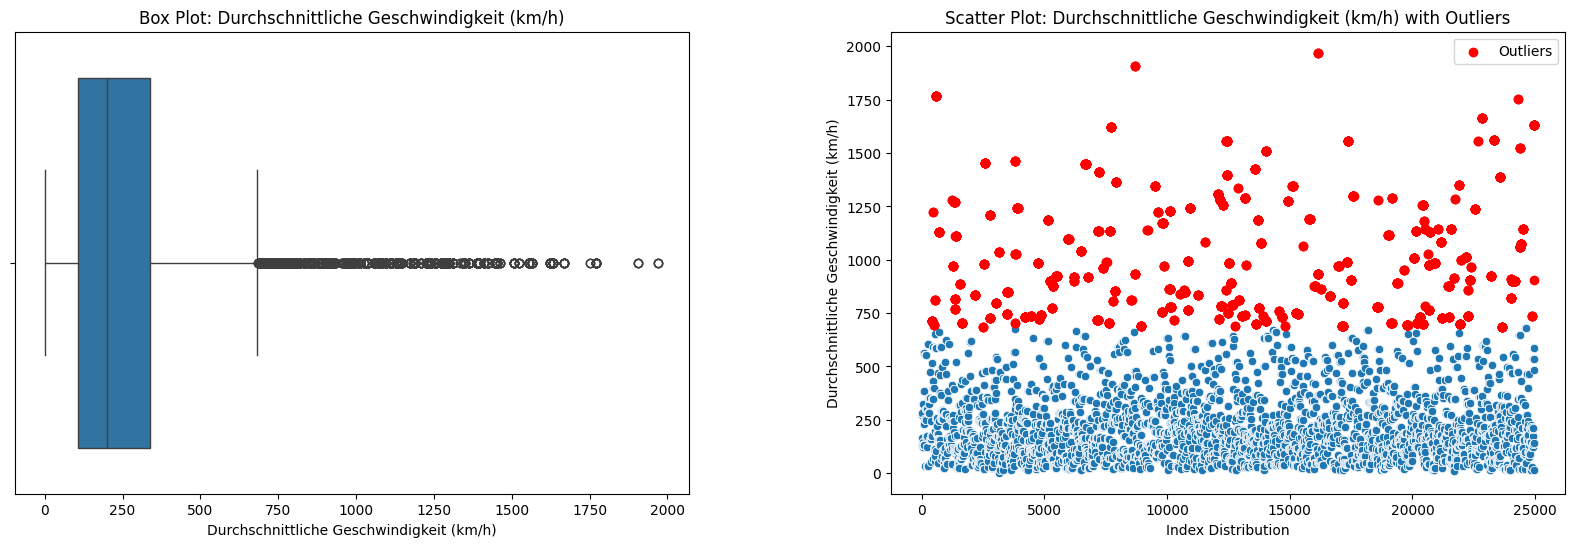

In [79]:
# Connect to SQLite database
conn = sqlite3.connect(sqlite_db_path)

# Load
query = 'SELECT * FROM obb_zugfahrten'
df = pd.read_sql_query(query, conn)

# Extract the relevant column
speed_column = 'Durchschnittliche Geschwindigkeit (km/h)'

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df[speed_column].quantile(0.25)
Q3 = df[speed_column].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df[speed_column] < lower_bound) | (df[speed_column] > upper_bound)]

# Subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Box plot
sns.boxplot(ax=axes[0], x=df[speed_column])
axes[0].set_title('Box Plot: Durchschnittliche Geschwindigkeit (km/h)')
axes[0].set_xlabel('Durchschnittliche Geschwindigkeit (km/h)')

# Scatter plot
sns.scatterplot(ax=axes[1], x=df.index, y=df[speed_column])
axes[1].scatter(outliers.index, outliers[speed_column], color='red', label='Outliers')
axes[1].set_title('Scatter Plot: Durchschnittliche Geschwindigkeit (km/h) with Outliers')
axes[1].set_xlabel('Index Distribution')
axes[1].set_ylabel('Durchschnittliche Geschwindigkeit (km/h)')
axes[1].legend()

# Adjust layout
plt.subplots_adjust(wspace=0.3)

# Show the plots
plt.show()

# Close the database connection
conn.close()

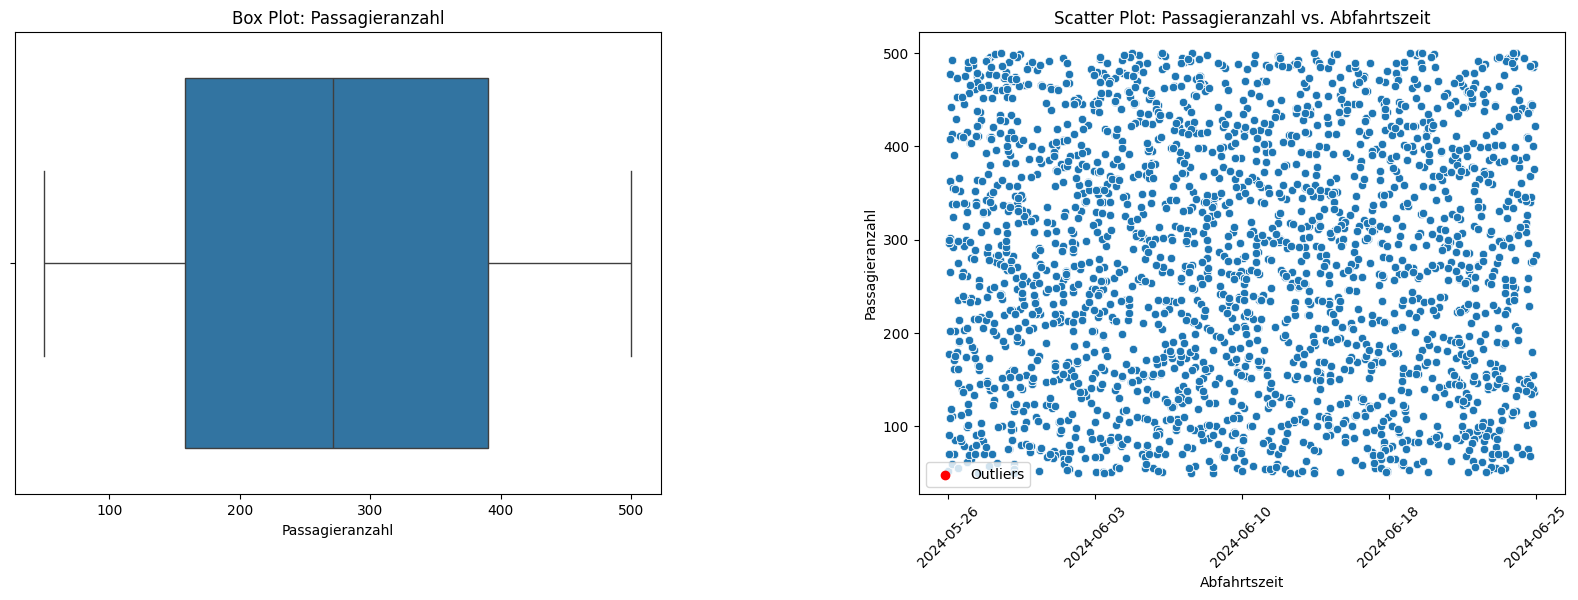

In [80]:
# Connect to SQLite database
conn = sqlite3.connect(sqlite_db_path)

# Load 
query = 'SELECT * FROM obb_zugfahrten'
df = pd.read_sql_query(query, conn)

# Extract the relevant columns
passenger_column = 'Passagieranzahl'
abfahrtszeit_column = 'Abfahrtszeit'

# Convert Abfahrtszeit to datetime and extract date
df[abfahrtszeit_column] = pd.to_datetime(df[abfahrtszeit_column])

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for passengers
Q1 = df[passenger_column].quantile(0.25)
Q3 = df[passenger_column].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df[passenger_column] < lower_bound) | (df[passenger_column] > upper_bound)]

# Subplots: box plot and scatter plot by Abfahrtszeit
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Box plot
sns.boxplot(ax=axes[0], x=df[passenger_column])
axes[0].set_title('Box Plot: Passagieranzahl')
axes[0].set_xlabel('Passagieranzahl')

# Scatter plot
sns.scatterplot(ax=axes[1], x=df[abfahrtszeit_column], y=df[passenger_column])
axes[1].scatter(outliers[abfahrtszeit_column], outliers[passenger_column], color='red', label='Outliers')
axes[1].set_title('Scatter Plot: Passagieranzahl vs. Abfahrtszeit')
axes[1].set_xlabel('Abfahrtszeit')
axes[1].set_ylabel('Passagieranzahl')
axes[1].legend()

# Set x-axis
unique_dates = np.linspace(df[abfahrtszeit_column].min().value, df[abfahrtszeit_column].max().value, 5).astype('datetime64[ns]')
axes[1].set_xticks(unique_dates)
axes[1].set_xticklabels(pd.to_datetime(unique_dates).strftime('%Y-%m-%d'), rotation=45)

# Adjust layout
plt.subplots_adjust(wspace=0.4)

# Show the plots
plt.show()

# Close the database connection
conn.close()

### 4.2. SQL Abfragen

In [81]:
# Connect to SQLite database
conn = sqlite3.connect(sqlite_db_path)

# Create a cursor object
cursor = conn.cursor()

# SQL query to count distinct Fahrtnummer
query = '''
    SELECT COUNT(DISTINCT Fahrtnummer) AS total_zugfahrten
    FROM obb_zugfahrten;
'''

# Execute the query
cursor.execute(query)

# Fetch and print the result
result = cursor.fetchone()
total_zugfahrten = result[0]
print(f"Total number of Zugfahrten: {total_zugfahrten}")

# Close the database connection
conn.close()

Total number of Zugfahrten: 2276


In [82]:
# Connect to SQLite database
conn = sqlite3.connect(sqlite_db_path)

# Create a cursor object
cursor = conn.cursor()

# SQL query to find all Fahrtnummer associated with the highest Fahrzeugnummer
query = '''
    SELECT Fahrtnummer, Fahrzeugnummer
    FROM obb_zugfahrten
    WHERE Fahrzeugnummer = (SELECT MAX(Fahrzeugnummer) FROM obb_zugfahrten);
'''

# Execute the query
cursor.execute(query)

# Fetch all results
results = cursor.fetchall()

# Get the unique Fahrtnummer values
unique_fahrtnummer = set(result[0] for result in results)

# Print the results
print("Zugfahrten with the highest Fahrzeugnummer:")
for fahrtnummer, fahrzeugnummer in results:
    print(f"Fahrtnummer: {fahrtnummer}, Fahrzeugnummer: {fahrzeugnummer}")

# Print the number of unique Fahrtnummer
print(f"Total number of unique Fahrtnummer: {len(unique_fahrtnummer)}")

# Close the database connection
conn.close()

Zugfahrten with the highest Fahrzeugnummer:
Fahrtnummer: 4079331200, Fahrzeugnummer: 20.0
Fahrtnummer: 7805182368, Fahrzeugnummer: 20.0
Fahrtnummer: 5379633811, Fahrzeugnummer: 20.0
Fahrtnummer: 1823139688, Fahrzeugnummer: 20.0
Fahrtnummer: 8383166655, Fahrzeugnummer: 20.0
Fahrtnummer: 4288119303, Fahrzeugnummer: 20.0
Fahrtnummer: 4580154267, Fahrzeugnummer: 20.0
Fahrtnummer: 9864188933, Fahrzeugnummer: 20.0
Fahrtnummer: 2144307276, Fahrzeugnummer: 20.0
Fahrtnummer: 2715301638, Fahrzeugnummer: 20.0
Fahrtnummer: 3146031977, Fahrzeugnummer: 20.0
Fahrtnummer: 4101111658, Fahrzeugnummer: 20.0
Fahrtnummer: 7891740102, Fahrzeugnummer: 20.0
Fahrtnummer: 9617754610, Fahrzeugnummer: 20.0
Fahrtnummer: 3041826626, Fahrzeugnummer: 20.0
Fahrtnummer: 4766575629, Fahrzeugnummer: 20.0
Fahrtnummer: 9476680420, Fahrzeugnummer: 20.0
Fahrtnummer: 7914825473, Fahrzeugnummer: 20.0
Fahrtnummer: 7246414642, Fahrzeugnummer: 20.0
Fahrtnummer: 2137196419, Fahrzeugnummer: 20.0
Fahrtnummer: 0899934143, Fahrzeugnum

In [83]:
# Connect to SQLite database
conn = sqlite3.connect(sqlite_db_path)

# Create a cursor object
cursor = conn.cursor()

# SQL query to count Zugfahrten in each year
query = '''
    SELECT strftime('%Y', Abfahrtsdatum) AS year, COUNT(DISTINCT Fahrtnummer) AS total_trips
    FROM obb_zugfahrten
    GROUP BY year;
'''

# Execute the query
cursor.execute(query)

# Fetch and print all results
results = cursor.fetchall()
print("Number of Zugfahrten in each year based on Abfahrtsdatum:")
for year, total_trips in results:
    print(f"Year: {year}, Total Zugfahrten: {total_trips}")

# Close the database connection
conn.close()

Number of Zugfahrten in each year based on Abfahrtsdatum:
Year: 2020, Total Zugfahrten: 507
Year: 2021, Total Zugfahrten: 496
Year: 2022, Total Zugfahrten: 541
Year: 2023, Total Zugfahrten: 481
Year: 2024, Total Zugfahrten: 251


In [84]:
# Connect to SQLite database
conn = sqlite3.connect(sqlite_db_path)

# Create a cursor object
cursor = conn.cursor()

# SQL query to count Zugfahrten in each year
query = '''
    SELECT strftime('%Y', Abfahrtszeit) AS year, COUNT(DISTINCT Fahrtnummer) AS total_trips
    FROM obb_zugfahrten
    GROUP BY year;
'''

# Execute the query
cursor.execute(query)

# Fetch and print all results
results = cursor.fetchall()
print("Number of Zugfahrten in each year based on Abfahrtszeit:")
for year, total_trips in results:
    print(f"Year: {year}, Total Zugfahrten: {total_trips}")

# Close the database connection
conn.close()

Number of Zugfahrten in each year based on Abfahrtszeit:
Year: 2024, Total Zugfahrten: 2276


In [85]:
# Connect to SQLite database
conn = sqlite3.connect(sqlite_db_path)

# Create a cursor object
cursor = conn.cursor()

# SQL query to get the earliest departure date and average Messung for each Buchungskreis
query = '''
    SELECT 
        Buchungskreis, 
        MIN(Abfahrtsdatum) AS earliest_departure_date, 
        AVG(Messung) AS average_messung
    FROM 
        obb_zugfahrten
    GROUP BY 
        Buchungskreis;
'''

# Execute the query
cursor.execute(query)

# Fetch and print all results
results = cursor.fetchall()
print("Earliest departure date and average Messung for each Buchungskreis:")
for buchungskreis, earliest_departure_date, average_messung in results:
    print(f"Buchungskreis: {buchungskreis}, Earliest Departure Date: {earliest_departure_date}, Average Messung: {average_messung}")

# Close the database connection
conn.close()

Earliest departure date and average Messung for each Buchungskreis:
Buchungskreis: 1000, Earliest Departure Date: 2020-01-05, Average Messung: 2756.768848857646
Buchungskreis: 1001, Earliest Departure Date: 2020-01-05, Average Messung: 2784.012180826903
Buchungskreis: 1002, Earliest Departure Date: 2020-01-04, Average Messung: 2755.3519296904865
Buchungskreis: 1003, Earliest Departure Date: 2020-01-01, Average Messung: 2747.9242222222256
Buchungskreis: 1004, Earliest Departure Date: 2020-01-26, Average Messung: 2728.437000483797
Buchungskreis: 1005, Earliest Departure Date: 2020-01-03, Average Messung: 2703.5846752136795
Buchungskreis: 1006, Earliest Departure Date: 2020-01-14, Average Messung: 2786.2737288888925
Buchungskreis: 1007, Earliest Departure Date: 2020-01-05, Average Messung: 2778.919550425278
Buchungskreis: 1008, Earliest Departure Date: 2020-01-08, Average Messung: 2772.9972594619217
Buchungskreis: 1009, Earliest Departure Date: 2020-01-11, Average Messung: 2754.5789742240

In [86]:
# Connect to SQLite database
conn = sqlite3.connect(sqlite_db_path)

# Create a cursor object
cursor = conn.cursor()

# SQL query to find the Buchungskreis with the highest total sum for train journeys in each year
query = '''
    WITH yearly_totals AS (
        SELECT 
            strftime('%Y', Abfahrtsdatum) AS year, 
            Buchungskreis, 
            SUM(Messung) AS total_sum
        FROM 
            obb_zugfahrten
        GROUP BY 
            year, Buchungskreis
    )
    SELECT 
        year, 
        Buchungskreis, 
        total_sum
    FROM 
        yearly_totals
    WHERE 
        (year, total_sum) IN (
            SELECT 
                year, 
                MAX(total_sum)
            FROM 
                yearly_totals
            GROUP BY 
                year
        )
    ORDER BY 
        year;
'''

# Execute the query
cursor.execute(query)

# Fetch and print all results
results = cursor.fetchall()
print("Buchungskreis with the highest total sum for train journeys in each year:")
for year, buchungskreis, total_sum in results:
    print(f"Year: {year}, Buchungskreis: {buchungskreis}, Total Sum: {total_sum}")

# Close the database connection
conn.close()


Buchungskreis with the highest total sum for train journeys in each year:
Year: 2020, Buchungskreis: 1007, Total Sum: 1690791.5900000003
Year: 2021, Buchungskreis: XXXX, Total Sum: 1739124.0599999963
Year: 2022, Buchungskreis: 1005, Total Sum: 1779162.6700000004
Year: 2023, Buchungskreis: 1000, Total Sum: 1443257.1199999985
Year: 2024, Buchungskreis: 1001, Total Sum: 1073632.1300000004


In [87]:
# Connect to SQLite database
conn = sqlite3.connect(sqlite_db_path)

# Create a cursor object
cursor = conn.cursor()

# SQL query to find the Buchungskreis with the highest trip count for train journeys in each year
query = '''
    WITH yearly_counts AS (
        SELECT 
            strftime('%Y', Abfahrtsdatum) AS year, 
            Buchungskreis, 
            COUNT(DISTINCT Fahrtnummer) AS trip_count
        FROM 
            obb_zugfahrten
        GROUP BY 
            year, Buchungskreis
    )
    SELECT 
        year, 
        Buchungskreis, 
        trip_count
    FROM 
        yearly_counts
    WHERE 
        (year, trip_count) IN (
            SELECT 
                year, 
                MAX(trip_count)
            FROM 
                yearly_counts
            GROUP BY 
                year
        )
    ORDER BY 
        year;
'''

# Execute the query
cursor.execute(query)

# Fetch and print all results
results = cursor.fetchall()
print("Buchungskreis with the highest trip count for train journeys in each year:")
for year, buchungskreis, trip_count in results:
    print(f"Year: {year}, Buchungskreis: {buchungskreis}, Trip Count: {trip_count}")

# Close the database connection
conn.close()

Buchungskreis with the highest trip count for train journeys in each year:
Year: 2020, Buchungskreis: XXXX, Trip Count: 57
Year: 2021, Buchungskreis: XXXX, Trip Count: 61
Year: 2022, Buchungskreis: 1007, Trip Count: 59
Year: 2023, Buchungskreis: 1005, Trip Count: 49
Year: 2024, Buchungskreis: 1001, Trip Count: 34


In [88]:
# Connect to SQLite database
conn = sqlite3.connect(sqlite_db_path)

# Create a cursor object
cursor = conn.cursor()

# SQL query to find the Fahrzeugnummer with the second highest Messung from the most recent train journey for each Buchungskreis
query = '''
    WITH latest_trips AS (
        SELECT 
            Buchungskreis, 
            MAX(Abfahrtsdatum) AS latest_date
        FROM 
            obb_zugfahrten
        GROUP BY 
            Buchungskreis
    ),
    recent_measurements AS (
        SELECT 
            o.Buchungskreis, 
            o.Fahrzeugnummer, 
            o.Messung,
            ROW_NUMBER() OVER (PARTITION BY o.Buchungskreis ORDER BY o.Messung DESC) AS row_num
        FROM 
            obb_zugfahrten o
        JOIN 
            latest_trips l
        ON 
            o.Buchungskreis = l.Buchungskreis AND o.Abfahrtsdatum = l.latest_date
    )
    SELECT 
        Buchungskreis, 
        Fahrzeugnummer, 
        Messung
    FROM 
        recent_measurements
    WHERE 
        row_num = 2;
'''

# Execute the query
cursor.execute(query)

# Fetch and print all results
results = cursor.fetchall()
print("Vehicle number with the second highest measurement from the most recent train journey for each Buchungskreis:")
for buchungskreis, fahrzeugnummer, messung in results:
    print(f"Buchungskreis: {buchungskreis}, Fahrzeugnummer: {fahrzeugnummer}, Messung: {messung}")

# Close the database connection
conn.close()

Vehicle number with the second highest measurement from the most recent train journey for each Buchungskreis:
Buchungskreis: 1000, Fahrzeugnummer: 13.0, Messung: 4380.87
Buchungskreis: 1001, Fahrzeugnummer: 8.0, Messung: 4380.21
Buchungskreis: 1002, Fahrzeugnummer: 10.0, Messung: 4288.14
Buchungskreis: 1003, Fahrzeugnummer: 12.0, Messung: 4826.1
Buchungskreis: 1004, Fahrzeugnummer: 4.0, Messung: 4563.62
Buchungskreis: 1005, Fahrzeugnummer: 10.0, Messung: 3373.15
Buchungskreis: 1006, Fahrzeugnummer: 5.0, Messung: 2988.31
Buchungskreis: 1007, Fahrzeugnummer: 12.0, Messung: 4516.45
Buchungskreis: 1008, Fahrzeugnummer: 1.0, Messung: 2565.67
Buchungskreis: 1009, Fahrzeugnummer: 1.0, Messung: 1483.79
Buchungskreis: XXXX, Fahrzeugnummer: 9.0, Messung: 4403.58


## 5. Datenqualität

In [89]:
# Load the data
csv_file_path = 'data/zugfahrten.csv'
df = pd.read_csv(csv_file_path)

# Initialize a list to hold validation error details
validation_errors = []

# Define validation functions
def validate_row(row):
    errors = []
    
    # Check for missing values
    for column in df.columns:
        if pd.isnull(row[column]):
            errors.append(f"Missing value in column {column}")
    
    # Check for invalid Zug id (no alphabetical values)
    if not pd.isnull(row['Zug id']) and re.search('[a-zA-Z]', str(row['Zug id'])):
        errors.append("Zug id contains alphabetical values")

    # Check for valid Abfahrtsdatum format
    try:
        pd.to_datetime(row['Abfahrtsdatum'], format='%Y-%m-%d')
    except ValueError:
        errors.append("Invalid Abfahrtsdatum format")

    # Check for valid Abfahrtszeit format
    try:
        pd.to_datetime(row['Abfahrtszeit'], format='%Y-%m-%d')
    except ValueError:
        errors.append("Invalid Abfahrtszeit format")

    # Check for valid Ankunftszeit format
    try:
        pd.to_datetime(row['Ankunftszeit'], format='%Y-%m-%d')
    except ValueError:
        errors.append("Invalid Ankunftszeit format")

    # Check for negative Messung
    if not pd.isnull(row['Messung']) and row['Messung'] < 0:
        errors.append("Negative value in Messung")
    
    # Check for invalid Entfernung km (no alphabetical values)
    if not pd.isnull(row['Entfernung km']) and re.search('[a-zA-Z]', str(row['Entfernung km'])):
        errors.append("Entfernung km contains alphabetical values")
    
    # Check for invalid Passagieranzahl (no alphabetical values)
    if not pd.isnull(row['Passagieranzahl']) and re.search('[a-zA-Z]', str(row['Passagieranzahl'])):
        errors.append("Passagieranzahl contains alphabetical values")
    
    return errors

# Check for duplicated rows
duplicated_rows = df[df.duplicated()]

# Validate each row and collect errors
for idx, row in df.iterrows():
    row_errors = validate_row(row)
    if row_errors:
        validation_errors.append({
            'index': idx,
            'Zug id': row['Zug id'],
            'errors': ', '.join(row_errors)
        })

# Add duplicated rows to validation errors
for idx in duplicated_rows.index:
    validation_errors.append({
        'index': idx,
        'Zug id': df.at[idx, 'Zug id'],
        'errors': 'Duplicated row'
    })

# Create a DataFrame for validation errors
errors_df = pd.DataFrame(validation_errors)

# Save validation errors to a separate CSV file
errors_csv_file_path = 'data/data_quality_validation_errors.csv'
errors_df.to_csv(errors_csv_file_path, index=False)

print(f"Validation complete. Found {len(validation_errors)} errors. See {errors_csv_file_path} for details.")

Validation complete. Found 27331 errors. See data/data_quality_validation_errors.csv for details.
